# 淘宝APP用户行为分析

## 前言：
本文针对淘宝app的运营数据，以行业常见指标对用户行为进行分析，包括日pv,uv分析，用户消费行为（付费率，ARPU,ARPPU）分析，复购行为分析，留存分析，漏斗流失分析和用户价值RFM分析等，来挖掘用户的行为模式，最后针对活跃度，留存，漏斗流失和RFM模型分析结果给出相应的运营建议。

由于数据缺少如购买金额和用户注册时间信息等，本文用消费次数代替金额来间接反映用户消费行为，用数据中用户第一次出现的时间作为注册登陆时间，因此分析会和实际指标如ARPU,ARPPU等的计算方式有一定差别，本文仅作分析逻辑参考。

## 数据集描述：
该数据包含1048576行，6列，文件名：tianchi_mobile_recommend_train_user.zip，文件大小约0.1GB。数据为淘宝APP2014年11月18日至2014年12月18日的用户行为数据，用户数量10000.数据下载链接：天池数据集

#### 列字段包含以下：

user_id：用户身份，脱敏

item_id：商品ID，脱敏

behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）

user_geohash：地理位置

item_category：品类ID（商品所属的品类）

time：用户行为发生的时间

## 正文：
### 一、数据清洗

In [1]:
from datetime import timedelta
from datetime import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
warnings.filterwarnings("ignore")
with open(r'tianchi_mobile_recommend_train_user.csv')as f:
    data_user = pd.read_csv(f)


In [3]:
#查看字段唯一值数量


def check_unique(data):
    for column in data.columns:
        print('{}唯一值数量:'.format(column), len(data[column].unique()))


#检查store表
check_unique(data_user)


user_id唯一值数量: 10000
item_id唯一值数量: 2876947
behavior_type唯一值数量: 4
user_geohash唯一值数量: 575459
item_category唯一值数量: 8916
time唯一值数量: 744


In [4]:
#查看数据集空值情况


def check_none(data):
    print('{:*^30}'.format('有空值的列'))
    print(data.isnull().any(axis=0))
    print('{:*^30}'.format('有空值的行数量'))
    print(data.isnull().any(axis=1).sum())


check_none(data_user)


************有空值的列*************
user_id          False
item_id          False
behavior_type    False
user_geohash      True
item_category    False
time             False
dtype: bool
***********有空值的行数量************
8334824


In [5]:
#转换为时间


def convert_to_time(data, column):
    #先对数据切分处理
    date = data[column].map(lambda x: x.split(' ')[0])
    hour = data[column].map(lambda x: x.split(' ')[1])
    #对日期类型转换
    date = date.map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    hour = hour.astype(np.int64)
    #改变原数据
    data[column] = date
    data['hour'] = hour
    return data


data1 = convert_to_time(data_user, 'time')
data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 7 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             datetime64[ns]
hour             int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 654.6+ MB


In [6]:
data_user = data1
#转换为字符串格式


def convert_to_str(data, columns):
    for i in columns:
        data[i] = data[i].astype('str')
    return data


data_user = convert_to_str(data_user, ['user_id', 'item_id', 'item_category'])
data_user.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 7 columns):
user_id          object
item_id          object
behavior_type    int64
user_geohash     object
item_category    object
time             datetime64[ns]
hour             int64
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 654.6+ MB


In [7]:
#给数据加一列，显示行为次数
data_user['operation'] = 1


### 二、用户行为分析
### 1.pv和uv分析

Text(0.5, 1.0, 'Daily UV')

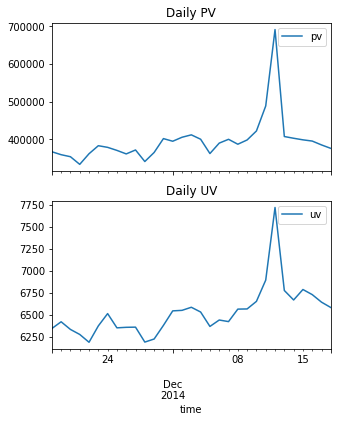

In [8]:
#pv记录每天用户操作次数，uv记录每天不同的上线用户数量
pv_daily = data_user.groupby('time')['user_id'].count(
).reset_index().rename(columns={'user_id': 'pv'})
uv_daily = data_user.groupby('time')['user_id'].apply(
    lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id': 'uv'})

fig, axes = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(5, 6)
pv_daily.plot(x='time', y='pv', ax=axes[0])
uv_daily.plot.line(x='time', y='uv', ax=axes[1])
axes[0].set_title('Daily PV')
axes[1].set_title('Daily UV')


看出双十二的浏览量最高,并且uv和pv差距很大，波动情况基本一样；从uv的分布，因为数据总人数为10000，所以日活率维持在60%以上浮动。

Text(0.5, 1.0, 'Hourly UV')

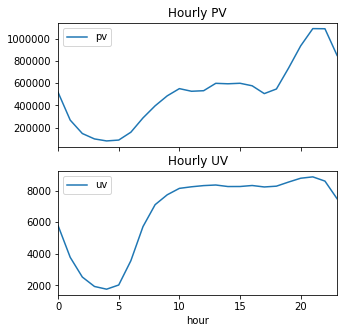

In [9]:
#时间段浏览量探寻
pv_hour = data_user.groupby('hour')['user_id'].count(
).reset_index().rename(columns={'user_id': 'pv'})
uv_hour = data_user.groupby('hour')['user_id'].apply(
    lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id': 'uv'})

fig, axes = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(5, 5)
pv_hour.plot.line(x='hour', y='pv', ax=axes[0])
uv_hour.plot.line(x='hour', y='uv', ax=axes[1])
axes[0].set_title('Hourly PV')
axes[1].set_title('Hourly UV')


可以发现在凌晨时间段pv和uv波动情况相似，但是从晚上大概18点这段时间，uv波动不大，而pv波动巨大，说明晚上是对app操作最频繁的时间段，我们可以将pv操作行为进行细分查看。

Text(0.5, 1.0, 'Different Behavior PV (Except Clicks)')

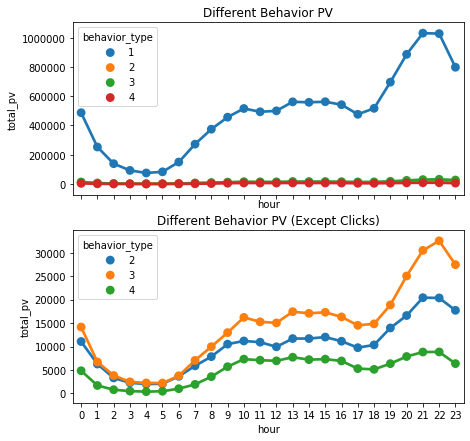

In [10]:
pv_detail = data_user.groupby(['behavior_type', 'hour'])['user_id'].count(
).reset_index().rename(columns={'user_id': 'total_pv'})

fig, axes = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(7, 7)
sns.pointplot(x='hour', y='total_pv', hue='behavior_type',
              data=pv_detail, ax=axes[0])
sns.pointplot(x='hour', y='total_pv', hue='behavior_type',
              data=pv_detail[pv_detail.behavior_type != 1], ax=axes[1])
axes[0].set_title('Different Behavior PV')
axes[1].set_title('Different Behavior PV (Except Clicks)')


可以看出点击情况比其他三类行为多很多，并且四种行为随着时间的波动情况基本一样。  
可以了解到用户基本都是在晚上这个时间段有更多的使用行为。  
同时，还发现加入购物车的量普遍比收藏量大，所以在后面漏斗分析可以把加入购物车作为收藏商品的前一步骤。  

### 2.用户消费行为分析

Text(0.5, 1.0, 'User Purchases')

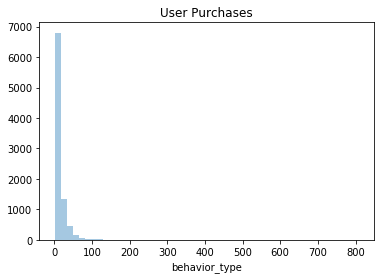

In [11]:
#用户购买次数分布
data_buy = data_user[data_user.behavior_type == 4].groupby('user_id')[
    'behavior_type'].count()
sns.distplot(data_buy, kde=False)
plt.title('User Purchases')


可以看出普遍消费次数都在100次以内。所以对于购买100次以上的可以作为重点用户进行关注。

Text(0.5, 1.0, 'Daily ARPPU')

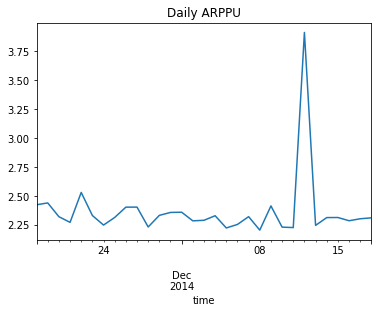

In [12]:
# 日ARPPU （Average Revenue Per Paying User),每付费用户平均收益
## 由于数据没有消费金额，因此用消费频率代替金额以做研究
## 人均消费次数=消费总次数/消费用户人数
data_buy2 = data_user[data_user.behavior_type == 4].groupby(['time', 'user_id'])[
    'behavior_type'].count().reset_index().rename(columns={'behavior_type': 'total'})
data_buy2.groupby('time').apply(lambda x: x.total.sum()/x.total.count()).plot()
plt.title('Daily ARPPU')


可以看出基本每天的消费用户平均消费次数在2次以上波动，双十二比较多。

Text(0.5, 1.0, 'Daily ARPU')

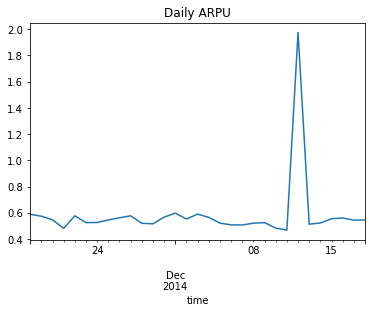

In [13]:
# 日ARPU (Average Revenue Per User)
## 活跃用户数平均消费次数=消费总次数/活跃用户人数(每天有操作行为的为活跃)
data_buy3 = data_user.groupby(['time', 'user_id', 'behavior_type'])[
    'operation'].count().reset_index().rename(columns={'operation': 'total'})
data_buy3.groupby('time').apply(
    lambda x: x[x.behavior_type == 4].total.sum()/len(x.user_id.unique())).plot()
plt.title('Daily ARPU')


可以看出基本每天活跃用户平均消费次数为0.5左右次。相当于每个人才产生一次消费行为。双十二比较多，达到2次。

Text(0.5, 1.0, 'Daily Payment Rate')

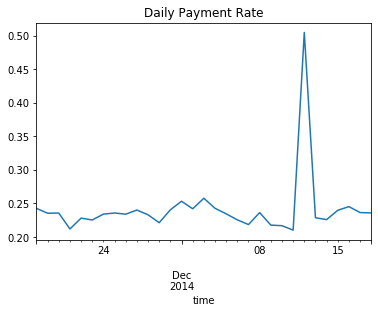

In [14]:
# 付费率=消费人数/活跃用户人数
data_buy3.groupby('time').apply(
    lambda x: x[x.behavior_type == 4].total.count()/len(x.user_id.unique())).plot()
plt.title('Daily Payment Rate')


看出每天活跃人群中只有0.2-0.25的活跃人群有消费行为。

大多数用户消费：1次


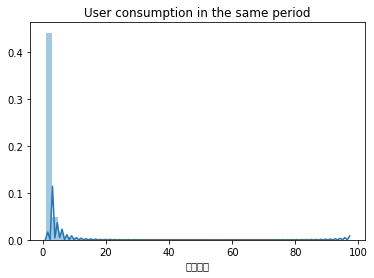

In [15]:
# 探索同一时间段用户消费次数的分布
data_buy4 = data_user[data_user.behavior_type == 4].groupby(
    ['user_id', 'time', 'hour'])['operation'].sum().rename('消费次数')
sns.distplot(data_buy4)
plt.title('User consumption in the same period')
print('大多数用户消费：{}次'.format(data_buy4.mode()[0]))  # mode求众数，返回数组形式


### 3.复购行为分析

In [16]:
# 复购情况，即两天以上有购买行为,一天多次购买算一次
# 复购率=有复购行为的用户数/有购买行为的用户总数
data_rebuy = data_user[data_user.behavior_type == 4].groupby(
    'user_id')['time'].apply(lambda x: len(x.unique())).rename('frequency')
#data_rebuy为找出每个用户有消费行为的天数
print('复购率：', round(data_rebuy[data_rebuy >= 2].count()/data_rebuy.count(), 4))


复购率： 0.8717


多数用户复购次数：0次


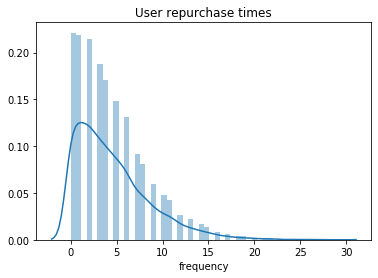

In [17]:
#对于有购买行为的用户复购次数分布
sns.distplot(data_rebuy-1)  # 需要减去1才是复购次数
plt.title('User repurchase times')
print('多数用户复购次数：{}次'.format((data_rebuy-1).mode()[0]))


In [18]:
# 复购天数分布情况
data_day_buy = data_user[data_user.behavior_type == 4].groupby(
    ['user_id', 'time']).operation.mean().reset_index()
# data_day_buy记录每个用户都哪些天有购买记录
data_day_buy.head()


,user_id,time,operation
0,100001878,2014-11-18,1
1,100001878,2014-11-24,1
2,100001878,2014-11-25,1
3,100001878,2014-11-26,1
4,100001878,2014-11-27,1


Text(0, 0.5, 'Frequency')

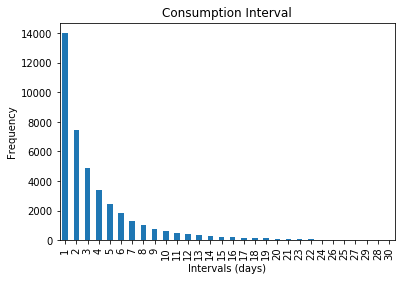

In [19]:
# 探索所有复购时间间隔的分布
day_buy5 = data_day_buy.groupby('user_id').time.apply(
    lambda x: x.sort_values().diff(1).dropna())
# day_buy5为对每位用户求出购买间隔时间
day_buy5 = day_buy5.map(lambda x: x.days)  # timedelta格式取天数

day_buy5.value_counts().plot(kind='bar')
plt.title('Consumption Interval')
plt.xlabel('Intervals (days)')
plt.ylabel('Frequency')


发现1-10天间隔呈现急速下降，下降速率不断变缓，到10 天后基本很少，说明有复购行为用户发生复购行为间隔基本在1-10天内，很少有人10天后才复购。

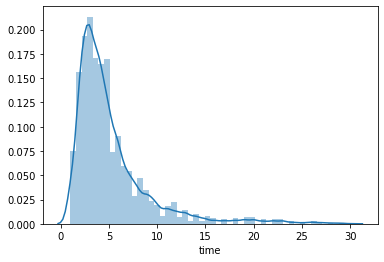

In [20]:
# 探索不同用户平均复购时间
sns.distplot(day_buy5.reset_index().groupby('user_id').time.mean())


可以看出整体复购时间随着天数增加呈现递减规律，而对于不同用户的平均复购时间，则呈现一个类正态分布，更多人的平均复购时间为1-5天。

### 4.留存分析

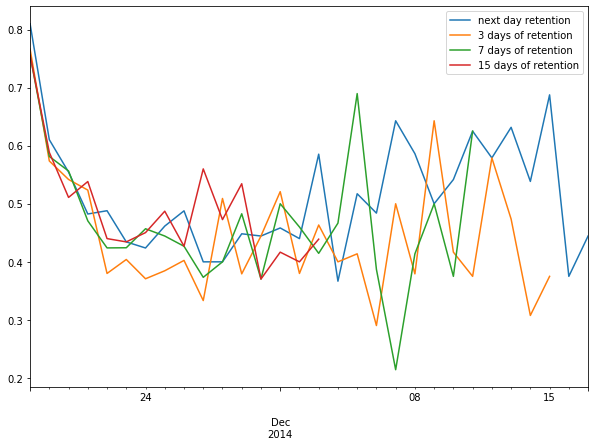

In [21]:
# 由于没有用户的注册时间信息，本次以用户第一次登陆作为注册时间

# 建立日留存函数


def check_retention(data, n):
    user = []
    date = pd.Series(data.time.unique()).sort_values()[:-n]  # 时间列明为time（参数）
    retention_rates = []
    for i in date:
        new_user = set(data[data.time == i].user_id.unique()
                       )-set(user)  # 用户列名为user_id(参数)
        user.extend(new_user)
        #第 n天留存情况
        user_nday = data[data.time == i +
                         timedelta(n)].user_id.unique()  # 第n天登录的用户集
        a = 0
        for user_id in user_nday:
            if user_id in new_user:
                a += 1
        retention_rate = a/len(new_user)
        retention_rates.append(retention_rate)
    data_retention = pd.Series(retention_rates, index=date)
    return data_retention


# 分别做次日，3日，7日，15天留存情况
data_1 = check_retention(data_user, 1)
data_3 = check_retention(data_user, 3)
data_7 = check_retention(data_user, 7)
data_15 = check_retention(data_user, 15)

# 作图
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
data_1.plot(ax=ax, label='next day retention')
data_3.plot(ax=ax, label='3 days of retention')
data_7.plot(ax=ax, label='7 days of retention')
data_15.plot(ax=ax, label='15 days of retention')
plt.legend(loc='best')


由于所选范围一开始时间把第一次登陆作为用户注册时间，这样17号这天会包含大量每天登陆的忠诚客户，所以第一天登陆的用户留存率很高。  
可以看出留存曲线交叉情况，这说明用户呈现间隔登陆，某日留存并非是用户流失，只是登陆时间不在该天。  
另外注意12月7号登陆的用户次日，3日，7日留存递减速度很快，这里需要注意，可能这天登陆的用户正在慢慢流失。

### 5.漏斗流失分析

In [22]:
# 探索每小时，每天漏斗流失,漏斗步骤为：点击-加入购物车-收藏-支付


def funnel(data, datetime):
    data1 = data.groupby([datetime, 'behavior_type']).operation.count(
    ).reset_index().rename(columns={'operation': 'total'})
    loss_rates = []
    date2 = pd.Series(data1[datetime].unique())  # 时间
    for i in date2:
        data2 = data1[data1[datetime] == i]
        click_to_car = 1-data2[data2.behavior_type == 3].reset_index(
        ).loc[0, 'total']/data2[data2.behavior_type == 1].reset_index().loc[0, 'total']
        car_to_collect = 1-data2[data2.behavior_type == 2].reset_index(
        ).loc[0, 'total']/data2[data2.behavior_type == 3].reset_index().loc[0, 'total']
        collect_to_pay = 1-data2[data2.behavior_type == 4].reset_index(
        ).loc[0, 'total']/data2[data2.behavior_type == 2].reset_index().loc[0, 'total']
        loss_rate = [click_to_car, car_to_collect, collect_to_pay]
        loss_rates.append(loss_rate)
    data3 = pd.DataFrame(loss_rates, index=date2, columns=[
                         'click_to_car_loss', 'car_to_collect_loss', 'collect_to_pay_loss'])
    return data3


data_hour_loss = funnel(data_user, 'hour')
data_day_loss = funnel(data_user, 'time')
data_day_loss.head()


,click_to_car_loss,car_to_collect_loss,collect_to_pay_loss
2014-11-18,0.970473,0.323933,0.459733
2014-11-19,0.970062,0.292931,0.484620
2014-11-20,0.969927,0.283873,0.516953
2014-11-21,0.972410,0.212813,0.557816
2014-11-22,0.970725,0.272618,0.507722


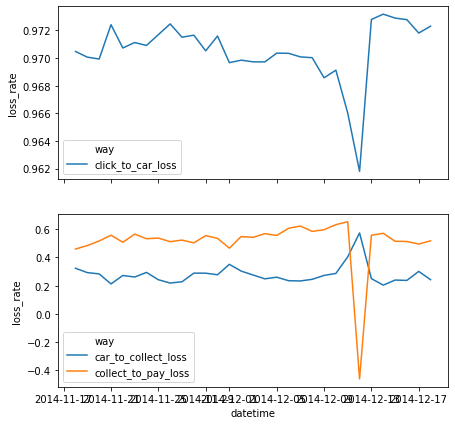

In [23]:
# 作图


def convert_to_pic(data):
    data_tem = data.stack().reset_index().rename(
        columns={'level_0': 'datetime', 'level_1': 'way', 0: 'loss_rate'})
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(7, 7)
    sns.lineplot(data=data_tem[data_tem.way == 'click_to_car_loss'],
                 x='datetime', y='loss_rate', hue='way', ax=axes[0])
    sns.lineplot(data=data_tem[data_tem.way != 'click_to_car_loss'],
                 x='datetime', y='loss_rate', hue='way', ax=axes[1])


# 观察每天流失情况
convert_to_pic(data_day_loss)


可以看出点击到加入购物车流失率特别高，在95%以上，而加入购物车到收藏和收藏到支付流失率分别在20%和50%左右，收藏到支付的流失率较高。  
另外可以看到波动比较稳定，除了双十二，这天点击流失率相对之前偏低，加入购物车到收藏流失变高，而收藏到支付流失则变成负，说明用户都是事先加入购物车然后直接购买的情况大量增加。

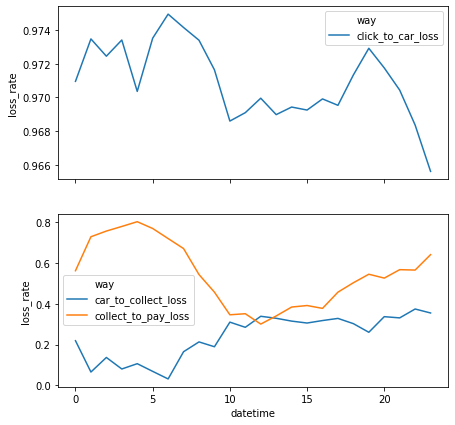

In [24]:
# 观察不同时间段流失情况
convert_to_pic(data_hour_loss)


可以看出凌晨时间段收藏到支付流失率很高，说明这段时间查看商品只为随便看看，产生支付的情况很少，或者预先手残后第二天早上支付。  
到晚上也是支付流失比较高的，因为这段时间用户有更积极取比较和思考是否要购买。

In [25]:
# 总体流失分析
data_totalloss = data_user.groupby('behavior_type').operation.count()
click_to_car = 1-data_totalloss[3]/data_totalloss[1]
car_to_collect = 1-data_totalloss[2]/data_totalloss[3]
collect_to_pay = 1-data_totalloss[4]/data_totalloss[2]
print('click_to_car loss rate:', click_to_car)
print('car_to_collect loss rate:', car_to_collect)
print('collect_to_pay loss rate:', collect_to_pay)


click_to_car loss rate: 0.9702556953628566
car_to_collect loss rate: 0.29400053556251526
collect_to_pay loss rate: 0.5044237207077953


### 6.用户行为与商品种类关系分析

In [26]:
# 不同类别转换率
data_category = data_user[data_user.behavior_type != 2].groupby(['item_category', 'behavior_type']).operation.count(
).unstack(1).rename(columns={1: 'click', 3: 'add_to_cart', 4: 'buy'}).fillna(0)
data_category.head(4)


behavior_type,click,add_to_cart,buy
item_category,,,
10,212.0,9.0,4.0
100,87.0,3.0,0.0
10000,18.0,0.0,0.0
10002,33.0,0.0,0.0


In [27]:
data_category['conversion_rates'] = data_category['buy']/data_category['click']
data_category.head()


behavior_type,click,add_to_cart,buy,conversion_rates
item_category,,,,
10,212.0,9.0,4.0,0.018868
100,87.0,3.0,0.0,0.000000
10000,18.0,0.0,0.0,0.000000
10002,33.0,0.0,0.0,0.000000
10010,1254.0,31.0,15.0,0.011962


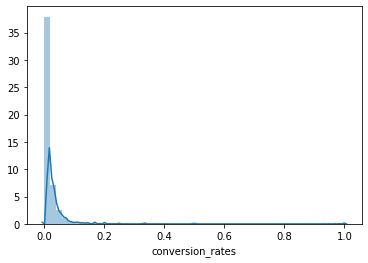

In [28]:
# 转换率分布情况
# 去掉异常
data_category['conversion_rates'] = data_category['conversion_rates'].fillna(0)
data_category = data_category[data_category['conversion_rates'] <= 1]
sns.distplot(data_category['conversion_rates'])


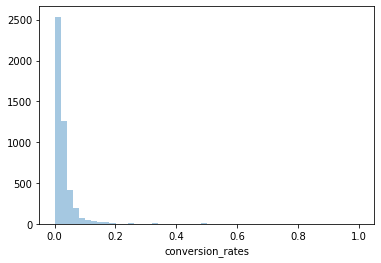

In [29]:
# 把转换率为0的排除掉
sns.distplot(data_category[data_category['conversion_rates']
                           > 0]['conversion_rates'], kde=False)


可以看出基本所有类别转换率都在0.1以内,并且大部分类别都没有购买情况。这部分类别需要重新审视以下为什么没有一次购买情况。

In [30]:
# 查看加入购物车的比例(即用户对商品感兴趣程度)
data_category['interest_ratio'] = data_category['add_to_cart'] / \
    data_category['click']
data_category.head()


behavior_type,click,add_to_cart,buy,conversion_rates,interest_ratio
item_category,,,,,
10,212.0,9.0,4.0,0.018868,0.042453
100,87.0,3.0,0.0,0.000000,0.034483
10000,18.0,0.0,0.0,0.000000,0.000000
10002,33.0,0.0,0.0,0.000000,0.000000
10010,1254.0,31.0,15.0,0.011962,0.024721


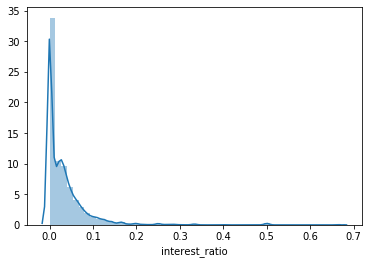

In [31]:
# 异常值去除
data_category = data_category[data_category['interest_ratio'] < 1]
sns.distplot(data_category['interest_ratio'])


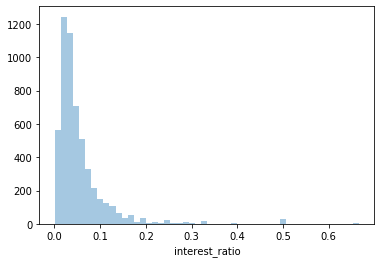

In [32]:
# 去掉没有被收藏的商品
sns.distplot(
    data_category[data_category['interest_ratio'] > 0]['interest_ratio'], kde=False)


可以发现加入购物车比例和转化率类似，基本也是0.1以内，说明用户点击的绝大多数商品并非感兴趣，这需要反思以下推荐系统或这其他相关因素了。

In [33]:
#将转化率分三类查看各类占比例
data_convert_rate = pd.cut(
    data_category['conversion_rates'], [-1, 0, 0.1, 1]).value_counts()
data_convert_rate = data_convert_rate/data_convert_rate.sum()
data_convert_rate


(0.0, 0.1]     0.503314
(-1.0, 0.0]    0.476351
(0.1, 1.0]     0.020335
Name: conversion_rates, dtype: float64

In [34]:
#将感兴趣程度分三类查看各类占比例
data_interest_rate = pd.cut(
    data_category['interest_ratio'], [-1, 0, 0.1, 1]).value_counts()
data_interest_rate = data_interest_rate/data_interest_rate.sum()
data_interest_rate


(0.0, 0.1]     0.539153
(-1.0, 0.0]    0.390855
(0.1, 1.0]     0.069992
Name: interest_ratio, dtype: float64

以上可以看出接近40%品类几乎没人感兴趣，达到0.1的也只有7%的品类，而从转化率看出更是有接近一半品类不被购买，达到0.1的转化率也只有2%的品类。

### 7.二八理论分析

In [35]:
# 二八原则和长尾理论
data_category = data_category[data_category['buy'] > 0]  # 排除没有购买量的品类
value_8 = data_category['buy'].sum()*0.8  # 算出前80%的购买量
value_10 = data_category['buy'].sum()  # 算出总购买量
data_category = data_category.sort_values(by='buy', ascending=False)
data_category['cumulative_purchases'] = data_category['buy'].cumsum()
data_category['classification'] = data_category['cumulative_purchases'].map(
    lambda x: 'top 80%' if x <= value_8 else 'last 20%')
data_category.head()


behavior_type,click,add_to_cart,buy,conversion_rates,interest_ratio,cumulative_purchases,classification
item_category,,,,,,,
6344,85369.0,3822.0,2208.0,0.025864,0.044770,2208.0,top 80%
1863,371738.0,9309.0,2000.0,0.005380,0.025042,4208.0,top 80%
5232,135506.0,4486.0,1611.0,0.011889,0.033106,5819.0,top 80%
6977,22806.0,2007.0,1324.0,0.058055,0.088003,7143.0,top 80%
8877,63396.0,1974.0,1072.0,0.016910,0.031138,8215.0,top 80%


In [36]:
data_category.groupby('classification')['classification'].count(
)/data_category['classification'].count()


classification
last 20%    0.844239
top 80%     0.155761
Name: classification, dtype: float64

可以发现前80%销量有不到20%的品类包办，典型的二八原则。但我们也看出有接近20%的销量由这85%的品类提供，对于传统零售由于受各种成本限制只能局限于这前20%的商品提供利润，而对于电子商务，由于没有了空间成本，使得这后80%的商品也可以销售出去，因此将长尾部分的商品优化推荐好，能够给企业带来更大的收益。

### 8.用户价值度RFM模型分析

In [37]:
# RFM：最近一次消费 (Recency)；消费频率 (Frequency)；消费金额 (Monetary)
date = datetime(2014, 12, 20)
# 找出每位用户最近购买时间
recent = data_user[data_user.behavior_type == 4].groupby('user_id').time.apply(lambda x: datetime(
    2014, 12, 20)-x.sort_values().iloc[-1]).reset_index().rename(columns={'time': 'recent'})
recent.recent = recent.recent.map(lambda x: x.days)  # 将间隔时间只保留天单位
# 找出每个用户消费频率
freq = data_user[data_user.behavior_type == 4].groupby(
    'user_id').time.count().reset_index().rename(columns={'time': 'freq'})
# 连接数据
rfm = pd.merge(recent, freq, left_on='user_id',
               right_on='user_id', how='outer')
rfm.head()


,user_id,recent,freq
0,100001878,2,36
1,100011562,4,3
2,100012968,2,15
3,100014060,2,24
4,100024529,4,26


In [38]:
# 将各维度分成三个程度,分数越高越好
rfm['recent_value']=pd.qcut(rfm.recent,3,labels=['3','2','1'])
rfm['freq_value']=pd.qcut(rfm.freq,3,labels=['1','2','3'])
rfm['rfm']=rfm['recent_value'].str.cat(rfm['freq_value'])

rfm.head()


,user_id,recent,freq,recent_value,freq_value,rfm
0,100001878,2,36,3,3,33
1,100011562,4,3,3,1,31
2,100012968,2,15,3,3,33
3,100014060,2,24,3,3,33
4,100024529,4,26,3,3,33


由于数据没有金额所以缺少消费金额（m）这一列。通过打分可以了解每位顾客的特性，从而实现差异化营销。比如:  
a. 对于33用户，为重点用户需要关注；  
b. 对于31这类忠诚度高而购买能力不足的，可以可以适当给点折扣或捆绑销售来增加用户的购买频率;  
c. 对于13这类忠诚度不高而购买能力强的，需要关注他们的购物习性做精准化营销。

### 三、结论

1. 通过pv，uv的不同时间维度分析，可以发现pv,uv随着时间呈现周期性变化，并且一天中不同时间段用户活跃度也不同，因此在做商品推广和广告营销尽量选择活跃度比较高的时间段会有更好效果。

2. 根据复购时间的分析，可以分析出用户普遍复购时间在3天左右，因此可以对超过3天未有购买的用户进行适当促销或优惠，能一定程度提高用户消费积极性。

3. 通过不同时间漏斗转化分析出流失率比较低的时间段，在这些时间段进行相应的商品推荐效果更优。

4. 通过对用户的RFM模型分析，可以有效对不同用户进行不同群体划分，不同群体采用不同的个性化营销手段，能产生更好的效益。